<a href="https://colab.research.google.com/github/DanielaLFreire/imagesearchengine/blob/main/Leo_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model analysis

this document has a set of scripts to generate a detailed analysis for reverse image search. Our objective is to use algorithms to extract features from images and build a descriptor of them with lower dimensions. After this step, we can use these descriptors to build our database and make the search for correlated images.

The analysis is focused on generalizing the capability of our models. We want to know the models rotating, zoom, translating, and noise invariant, to ensure robustness and reduce attack possibilities.

Initially, we are testing with a database composed of 500 samples but the number will increase progressively to ensure the performance and for better know all weakness of our system.

In [1]:
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import math
import time
import psutil

from PIL import Image, ImageOps
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None #DecompressionBombError: Image size ...

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import shift, uniform_filter, zoom
from skimage.exposure import adjust_gamma
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.feature import daisy
from sklearn.decomposition import PCA
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading images

In this step, we are reading all images and converting them into numpy.array. Their size is 224 x 224 in grayscale.

In [3]:
dir_path='/content/drive/Shareddrives/Projeto_TJSP/arquivos'
class_names=np.array(os.listdir(dir_path))

In [ ]:
class_names

array(['deposito_oficiais', 'gare', 'outros', 'recolhimento',
       'deposito_despesas', 'dare', 'comprovante'], dtype='<U17')

In [4]:
img_size =224

In [5]:
img_names = []
test_path = []
img_array_list = []
img_name_list = []

for cl in class_names:
  cl_path = dir_path + '/' + cl
  test_path.append(cl_path)
  img_names = os.listdir(cl_path)

  path, dirs, files = next(os.walk(cl_path))
  file_count = len(files)
  img_name_list.append(img_names)

  for i in range(file_count):
    img_path = cl_path + '/' + img_names[i]
    img_path = cl_path + '/' + img_names[i]
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize((img_size ,img_size ))
    img = np.asarray(img)
    img_array_list.append(img)
  print(cl, file_count,len(img_array_list))

deposito_oficiais 302 302
gare 74 376
outros 410 786
recolhimento 806 1592
deposito_despesas 285 1877
dare 916 2793
comprovante 655 3448


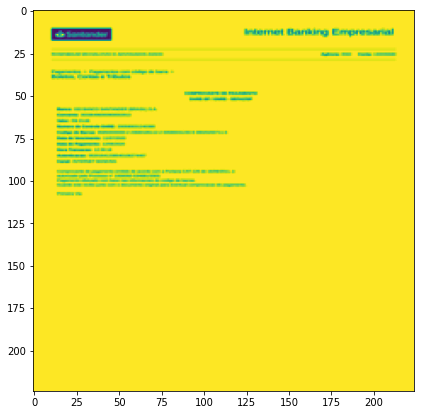

In [16]:
plt.figure(figsize=(10, 7))
plt.imshow(img)

## Descriptors extraction

Here we load the model. In this example, we are using a pre-trained model built using Tensorflow, but other models can be used.

This example uses an architecture of convolutional autoencoder, composed of two parts, the encoder, and the decoder. The encoder part will create a new representation of the input and the decoder will use this new representation to create the input. The decoder part is important only for the training stage, then we remove all layers of this part.

In [17]:
class extractor_orb():

  def __init__(self):
    self.orb = cv2.ORB_create(edgeThreshold=8, patchSize=20, nlevels=8, 
                              fastThreshold=20, scaleFactor=1.2, WTA_K=2,
                              scoreType=cv2.ORB_HARRIS_SCORE, firstLevel=0, 
                              nfeatures=25)
    
  def predict(self, X):
    arrays = []
    if X.dtype != 'uint8' and X.max() == 1 and X.min()==0:
      X = X*255
      X = X.astype('uint8')
    for img in X:
      kp, des =  self.orb.detectAndCompute(img, None)
      if (type(des) == type(None)):
        hist, bin_edges = np.histogram([], 255, range=[0, 255])
      else:
        hist, bin_edges = np.histogram(des, 255, range=[0, 255])
        norm_orb = np.linalg.norm(hist)
        hist = hist/norm_orb
      arrays.append(hist)
    return arrays

In [18]:
ext_orb = extractor_orb()

In [19]:
class extractor_lbp():
  def __init__(self, radius, n_points):
    self.radius = radius
    self.n_points = n_points

  def predict(self, X):
    des_images = []
    for img in X:
      lbp_res = local_binary_pattern(img, self.n_points, self.radius, 'uniform')
      des, _ = np.histogram(lbp_res.ravel(), bins=np.arange(0, self.n_points + 3),
                            range=(0, self.n_points + 2), density=True)
      des_images.append(des)
    return des_images

In [10]:
ext_lbp = extractor_lbp(25, 159)

In [11]:
class extractor_hog():

  def predict(self, X):
    arrays = []
    for img in X:
      descriptor = hog(img, 10, (16, 16), (2, 2), visualize=False, multichannel=False)
      arrays.append(descriptor)
    return arrays

In [12]:
ext_hog = extractor_hog()

In [13]:
class extractor_daisy():
    
  def predict(self, X):
    des_images = []
    for img in X:
      des = daisy(img, visualize=False)
      des = des.flatten()
      des_images.append(des)
    return des_images

In [ ]:
ext_daisy = extractor_daisy()

In [21]:
num_images=len(img_array_list)
batch_size = 64
num_epochs = int(math.ceil(num_images / batch_size))
#seed=10

## Search algorithm initialization

For testing, we are using the NearestNeighbors algorithms from Sklearn. Our database has only 3448 samples, then the performance is enough for now.

The inputs are the descriptors generated by the algorithm loaded above which have used the original images (without any change like rotation) to generate them. On our tests, we have just 3448 images as a possible results. All other images generated are used to do the reverse search.

In [14]:
neighbors = NearestNeighbors(n_neighbors=1, metric='cosine')

In [15]:
output_path='/content/drive/Shareddrives/Projeto_TJSP/simulations/'

**Using architecture of convolutional autoencoder**

In [28]:
#Extract all descriptors and populate with the descriptors - orb

array_acc = []
array_duration = []
array_cpu = []
array_memory = []

for i in range(20):
  t = 0
  start = time.time()
  p = psutil.Process(os.getpid())
  #Extract all descriptors and populate with the descriptors
  test_descriptors = ext_orb.predict(np.array(img_array_list))
  neighbors.fit(test_descriptors, range(num_images))
  # Run a test to search the images of our dataset
  predict = neighbors.kneighbors(test_descriptors, n_neighbors=1, return_distance=False)
  acc = 0
  for i in range(num_images):
    if (predict[i] == i):
      acc +=1
  end = time.time()
  duration = end-start
  cpu_user = p.cpu_times()[0]

  #array_duration.append(duration)
  #array_acc.append(acc/num_images)

  array_cpu.append(cpu_user)#user: time spent by normal processes executing in user mode; on Linux this also includes guest time
  array_memory.append(p.memory_percent())
 
#df_duration_orb= pd.DataFrame(array_duration)
#df_acc_orb = pd.DataFrame(array_acc)

#df_duration_orb.to_csv(output_path+'duration_orb.csv', index=False, header=False)
#df_acc_orb.to_csv(output_path+'acc_orb.csv', index=False, header=False)

df_cpu_orb = pd.DataFrame(array_cpu)
df_memory_orb = pd.DataFrame(array_memory)

df_cpu_orb.to_csv(output_path+'cpu_orb.csv', index=False, header=False)
df_memory_orb.to_csv(output_path+'memory_orb.csv', index=False, header=False)

In [1]:
#Extract all descriptors and populate with the descriptors - lbo

array_acc = []
array_duration = []
array_cpu = []
array_memory = []

for i in range(20):
  t = 0
  start = time.time()
  p = psutil.Process(os.getpid())
  test_descriptors = ext_lbp.predict(np.array(img_array_list))
  neighbors.fit(test_descriptors, range(num_images))
  # Run a test to search the images of our dataset
  predict = neighbors.kneighbors(test_descriptors, n_neighbors=1, return_distance=False)
  acc = 0
  for i in range(num_images):
    if (predict[i] == i):
      acc +=1
  end = time.time()
  duration = end-start
  cpu_user = p.cpu_times()[0]

  #array_duration.append(duration)
  #array_acc.append(acc/num_images)

  array_cpu.append(cpu_user)#user: time spent by normal processes executing in user mode; on Linux this also includes guest time
  array_memory.append(p.memory_percent())
 
 
#df_duration_lbp = pd.DataFrame(array_duration)
#df_acc_lbp = pd.DataFrame(array_acc)

#df_duration_lbp.to_csv(output_path+'duration_lbp.csv', index=False, header=False)
#df_acc_lbp.to_csv(output_path+'acc_lbp.csv', index=False, header=False)

df_cpu_lbp = pd.DataFrame(array_cpu)
df_memory_lbp = pd.DataFrame(array_memory)

df_cpu_lbp.to_csv(output_path+'cpu_lbp.csv', index=False, header=False)
df_memory_lbp.to_csv(output_path+'memory_lbp.csv', index=False, header=False)

NameError: ignored

In [ ]:
#Extract all descriptors and populate with the descriptors - hog

array_acc = []
array_duration = []
array_cpu = []
array_memory = []

for i in range(20):
  t = 0
  start = time.time()
  p = psutil.Process(os.getpid())
  test_descriptors = ext_hog.predict(np.array(img_array_list))
  neighbors.fit(test_descriptors, range(num_images))
  # Run a test to search the images of our dataset
  predict = neighbors.kneighbors(test_descriptors, n_neighbors=1, return_distance=False)
  acc = 0
  for i in range(num_images):
    if (predict[i] == i):
      acc +=1
  end = time.time()
  duration = end-start
  cpu_user = p.cpu_times()[0]

  #array_duration.append(duration)
  #array_acc.append(acc/num_images)

  array_cpu.append(cpu_user)#user: time spent by normal processes executing in user mode; on Linux this also includes guest time
  array_memory.append(p.memory_percent())

 
#df_duration_hog= pd.DataFrame(array_duration)
#df_acc_hog = pd.DataFrame(array_acc)

#df_duration_hog.to_csv(output_path+'duration_hog.csv', index=False, header=False)
#df_acc_hog.to_csv(output_path+'acc_hog.csv', index=False, header=False)

df_cpu_hog = pd.DataFrame(array_cpu)
df_memory_hog = pd.DataFrame(array_memory)

df_cpu_hog.to_csv(output_path+'cpu_hog.csv', index=False, header=False)
df_memory_hog.to_csv(output_path+'memory_hog.csv', index=False, header=False)


In [ ]:
#Extract all descriptors and populate with the descriptors - daisy

array_acc = []
array_duration = []
array_cpu = []
array_memory = []

for i in range(1):
  t = 0
  start = time.time()
  p = psutil.Process(os.getpid())
  #Extract all descriptors and populate with the descriptors
  test_descriptors = ext_daisy.predict(np.array(img_array_list))
  pca = PCA(n_components=0.9)
  test_descriptors = pca.fit_transform(test_descriptors)
  neighbors.fit(test_descriptors, range(num_images))
  # Run a test to search the images of our dataset
  predict = neighbors.kneighbors(test_descriptors, n_neighbors=1, return_distance=False)
  acc = 0
  for i in range(num_images):
    if (predict[i] == i):
      acc +=1
  end = time.time()
  duration = end-start

  array_duration.append(duration)
  array_acc.append(acc/num_images)

  array_cpu.append(p.cpu_times[0])
  array_memory(p.memory_percent())
 
df_duration_daisy= pd.DataFrame(array_duration)
df_acc_daisy = pd.DataFrame(array_acc)

df_duration_daisy.to_csv(output_path+'duration_daisy.csv', index=False, header=False)
df_acc_daisy.to_csv(output_path+'acc_daisy.csv', index=False, header=False)

df_cpu_daisy = pd.DataFrame(array_cpu)
df_memory_daisy = pd.DataFrame(array_memory)

df_cpu_daisy.to_csv(output_path+'cpu_daisy.csv', index=False, header=False)
df_memory_daisy.to_csv(output_path+'memory_daisy.csv', index=False, header=False)

In [ ]:
df_acc_daisy

## Functions


In [ ]:
"""
  Generate a set of random number used to augment images

  min(int): minimum value to be drawn
  max(int): maximum value to be drawn
  shape(tuple): output shape
  step(optional): interval size between the min and max values 
  factor(optional): fatctor to multiply all generated numbers
  plot_distribution(optional): if plots the generated values distribution
  plot_title(optional): Title of the distribution plot
  x_label(optional): label of x axis
  y_label(optional): label of y axis
"""
def random_params(min, max, shape, step=None, factor=1, plot_distribution=True,
                  bins=20, plot_title=None, x_label=None, y_label=None):
  #Calculate the step value if it is None
  if step == None:
    step = max - min
  rand_set = []
  #Generate the set of random numbers
  for i in range(min, max, step):
    rand_nums = np.random.randint(i, i+step, shape)*factor
    rand_set.append(rand_nums)
  #Plot the data distribution
  if plot_distribution:
    plt.figure(figsize=(10, 6))
    g1 = sns.distplot(rand_set, bins=bins)
    g1.set_title(plot_title)
    g1.set_xlabel(x_label)
    g1.set_ylabel(y_label)
  return rand_set

In [ ]:
"""
  Print some examples of generated images using data agumentation

  images(5-D array): generated images
  num_images(int): number of images to print
  rows(int): number of rows on the sublplot
  cols(int): number of columns on the subplot
"""
def print_images(images, num_images, rows, cols):
  #Create a figure of subplots
  fig, axr = plt.subplots(rows, cols)
  #Define figure dimensions 
  fig.set_figwidth(30)  
  fig.set_figheight(10)
  #Plot each image
  for i in range(num_images):
    #Calculate grid position of the image
    pos_x = int(i/cols)
    pos_y = i%cols
    #Plot image
    if rows == 1:
      axr[pos_y].imshow(images[i, 0, :, :])
    else:
      axr[pos_x, pos_y].imshow(images[i, 0, :, :])

In [ ]:
"""
  Get accuracy for a certain number of images returned

  return_num (int): number of images retieved
  num_bins (int): number of tests
  total_images(int): number of images for each test
  params(list): 2 parameters for label calculation

  return:
    Acc (list): list of accuracy for each test
    label (list): list of labels for each test
"""
def get_accuracy(return_num, num_tests, total_images, params):
  acc = []
  labels = []
  #Iterate overeach test
  for i in range(num_tests):
    temp_corrects = 0
    #Iterate over images
    for j in range(total_images):
      #Check if the image has been recoverd
      if j in search_results[i][j][0:return_num]:
        temp_corrects += 1
      #Calcultate the label
    n = i*params[0] + params[1]
    #Store the label and the accuracy
    labels.append(f'[{n}, {n+params[0]}]')
    acc.append(temp_corrects/total_images)
  return acc, labels

In [ ]:
"""
  Plot the accuracy for each range level of modification

  labels (list): label for each column
  acc (list): accuracy of each modification level
  title (string): plot title
  xlable (string): lable of x axis
  ylable (string): lable of y axis
"""
def plot_results(labels, acc, title, xlabel, ylabel):
  #Create the figure to plot the accuracy
  plt.figure(figsize=(12, 8))
  #Set data and lables for plotting
  acc_dist = sns.barplot(x=labels, y=acc)
  acc_dist.set_title(title)
  acc_dist.set_xlabel(xlabel)
  acc_dist.set_ylabel(ylabel)
  acc_dist.set_ylim(0, 1)
  acc_dist.grid()
  #Delete the accuracy array
  del acc

## Rotation analysis

In this part, we are going to analyze the capability of our model to recognize rotated images. For that, we generate 12 more images for each one of our databases rotating from -180 degrees to 180 degrees with a step of 30 degrees. The graph below shows us a quasi-uniform distribution of angles.

With this range of angles, we can know where are the fails of our model and its generalization capability.

In [ ]:
angles = random_params(-180, 180, (500,), 30, plot_title='Rotation angle distribution',
                       bins=36, x_label='Angle (degrees)', y_label='Density')

In [ ]:
#Generates all roted images
img_rotated = []
for img_angles in angles:
  temp_rotated = []
  for ang, img in zip(img_angles, img_array_list):
    img = rotate(img, ang, mode='constant', cval=1)
    temp_rotated.append(img)
  img_rotated.append(temp_rotated)
img_rotated = np.array(img_rotated)

In [ ]:
print_images(img_rotated, 12, 2, 6)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/rotation/'

**orb**

In [ ]:
# Reseach guias using rotated images as input
search_results = []

num_rotate_bins = img_rotated.shape[0]
for i in range(num_rotate_bins):
  descriptors = ext_orb.predict(img_rotated[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)
  
del img_rotated


### Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_rotate_bins, 500, (30, -180))

In [ ]:
plot_results(labels, acc_1, 'Accuracy by rotated angle for 1 result - ORB', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png') #esta linha cria um arquivo png com o gráfico

### Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_rotate_bins, 500, (30, -180))

In [ ]:
plot_results(labels, acc_5, 'Accuracy by rotated angle for 5 results - ORB', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png') #esta linha cria um arquivo png com o gráfico

### Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_rotate_bins, 500, (30, -180))

In [ ]:
plot_results(labels, acc_10, 'Accuracy by rotated angle for 10 results - ORB', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top10_ORB.png') #esta linha cria um arquivo png com o gráfico

**LBP**

In [ ]:
# Reseach guias using rotated images as input
search_results = []

num_rotate_bins = img_rotated.shape[0]
for i in range(num_rotate_bins):
  descriptors = ext_lbp.predict(img_rotated[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)
  
del img_rotated

### Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_1, 'Accuracy by rotated angle for 1 result - LBP', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')

### Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_5, 'Accuracy by rotated angle for 5 results - LBP', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

### Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_10, 'Accuracy by rotated angle for 10 results - LBP', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')

**HOG**

In [ ]:
# Reseach guias using rotated images as input
search_results = []

num_rotate_bins = img_rotated.shape[0]
for i in range(num_rotate_bins):
  descriptors = ext_hog.predict(img_rotated[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)
  
del img_rotated

### Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_1, 'Accuracy by rotated angle for 1 results - HOG', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

### Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_5, 'Accuracy by rotated angle for 5 results - HOG', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

### Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_10, 'Accuracy by rotated angle for 10 results - HOG', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using rotated images as input
search_results = []

num_rotate_bins = img_rotated.shape[0]
for i in range(num_rotate_bins):
  descriptors = ext_daisy.predict(img_rotated[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)
  
del img_rotated

### Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_1, 'Accuracy by rotated angle for 1 result - DAISY', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top1_DAISY.png')

### Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_5, 'Accuracy by rotated angle for 5 results - DAISY', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top5_DAISY.png')

### Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_rotate_bins, 500, (30, -180))
plot_results(labels, acc_10, 'Accuracy by rotated angle for 10 results - DAISY', 
             'Angles range (degrees)', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')

## Image shift analysis

Shifted images can confuse the algorithm. We make this test to know if the system can deal with shifted images up to 10% of their size.

In [ ]:
shifts = random_params(-20, 20, (500,2), 5, plot_title='Shift level distribution',
                       bins=20, x_label='Shift level (pixels)', y_label='Density')

In [ ]:
#Generates all shifted images
img_shift = []
for img_step in shifts:
  temp_shift = []
  for s, img in zip(img_step, img_array_list):
    img = shift(img, s)
    temp_shift.append(img)
  img_shift.append(temp_shift)
img_shift = np.array(img_shift)

In [ ]:
print_images(img_shift, 8, 2, 4)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/shift/'

**ORB**

In [ ]:
# Reseach guias using shifted images as input
search_results = []

num_shift_bins = img_shift.shape[0]
for i in range(num_shift_bins):
  descriptors = ext_orb.predict(img_shift[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_shift

Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_shift_bins, 500, (5, -20))

In [ ]:
plot_results(labels, acc_1, 'Accuracy of translated images for 1 result - ORB', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png')

Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_shift_bins, 500, (5, -20))

In [ ]:
plot_results(labels, acc_5, 'Accuracy of translated images for 5 results - ORB', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png')

Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_shift_bins, 500, (5, -20))

In [ ]:
plot_results(labels, acc_10, 'Accuracy of translated images for 10 results - ORB', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_ORB.png')

**LBP**

In [ ]:
# Reseach guias using shifted images as input
search_results = []

num_shift_bins = img_shift.shape[0]
for i in range(num_shift_bins):
  descriptors = ext_lbp.predict(img_shift[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_shift

Top-1 test

---



In [ ]:
acc_1, labels = get_accuracy(1, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_1, 'Accuracy of translated images for 1 result - LBP', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')


Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_5, 'Accuracy of translated images for 5 results - LBP', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_10, 'Accuracy of translated images for 10 results - LBP', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')

**HOG**

In [ ]:
# Reseach guias using shifted images as input
search_results = []

num_shift_bins = img_shift.shape[0]
for i in range(num_shift_bins):
  descriptors = model_HOG.predict(img_shift[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_shift

Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_1, 'Accuracy of translated images for 1 result - HOG', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_5, 'Accuracy of translated images for 5 results - HOG', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_10, 'Accuracy of translated images for 10 results - HOG', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using shifted images as input
search_results = []

num_shift_bins = img_shift.shape[0]
for i in range(num_shift_bins):
  descriptors = ext_daisy.predict(img_shift[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_shift

Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_1, 'Accuracy of translated images for 1 result - DAISY', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_5, 'Accuracy of translated images for 5 results - DAISY', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_shift_bins, 500, (5, -20))
plot_results(labels, acc_10, 'Accuracy of translated images for 10 results - DAISY', 
             'Shift level (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')

## Blur analysis

Blurring image is a simple operation that can be done using an average filter. The blur level changes with the size of the average filter size, for the big filter, the image is has a high level of blur, for small filters, the resolution is better.

In [ ]:
blur = random_params(2, 22, (500,), 2, plot_title='Blur level distribution',
                       bins=20, x_label='Average filter size (pixels)', y_label='Density')

In [ ]:
#Generates all blured images
img_blur = []
for img_level in blur:
  temp_blur = []
  for s, img in zip(img_level, img_array_list):
    s = (s, s)
    img = uniform_filter(img, size=s)
    temp_blur.append(img)
  img_blur.append(temp_blur)
img_blur = np.array(img_blur)

In [ ]:
print_images(img_blur, 10, 2, 5)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/blur/'

**ORB**

In [ ]:
# Reseach guias using blured images as input
search_results = []
num_blur_bins = img_blur.shape[0]
for i in range(num_blur_bins):
  descriptors = ext_orb.predict(img_blur[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_blur

### Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_blur_bins, 500, (2, 2))

In [ ]:
plot_results(labels, acc_1, 'Accuracy of blured images for 1 result - ORB', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png')

### Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_blur_bins, 500, (2, 2))

In [ ]:
plot_results(labels, acc_5, 'Accuracy of blured images for 5 results - ORB', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png')

### Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_blur_bins, 500, (2, 2))

In [ ]:
plot_results(labels, acc_10, 'Accuracy of blured images for 10 results', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_ORB.png')

**LBP**

In [ ]:
# Reseach guias using blured images as input
search_results = []
num_blur_bins = img_blur.shape[0]
for i in range(num_blur_bins):
  descriptors = ext_lbp.predict(img_blur[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_blur

Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_1, 'Accuracy of blured images for 1 result - LBP', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')

Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_5, 'Accuracy of blured images for 5 results - LBP', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_10, 'Accuracy of blured images for 10 results - LBP', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')


**HOG**

In [ ]:
# Reseach guias using blured images as input
search_results = []
num_blur_bins = img_blur.shape[0]
for i in range(num_blur_bins):
  descriptors = model_HOG.predict(img_blur[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_blur

Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_1, 'Accuracy of blured images for 1 result - HOG', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_5, 'Accuracy of blured images for 5 results - HOG', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_10, 'Accuracy of blured images for 10 results - HOG', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using blured images as input
search_results = []
num_blur_bins = img_blur.shape[0]
for i in range(num_blur_bins):
  descriptors = ext_daisy.predict(img_blur[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_blur

Test1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_1, 'Accuracy of blured images for 1 result - DAISY', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top1_DAISY.png')

Test5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_5, 'Accuracy of blured images for 5 results - DAISY', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top5_DAISY.png')

Test10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_blur_bins, 500, (2, 2))
plot_results(labels, acc_10, 'Accuracy of blured images for 10 results - DAISY', 
             'Average filter size (pixels)', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')

## Gamma analysis

The gamma changes the intensity of the image content, making it brighter or darker than the normal image. Lighter images can be harder to identify due to confusion with the background color.

In [ ]:
gamma = random_params(1, 1000, (500,), 100, factor=1/1000, plot_title='Gamma level distribution',
                       bins=20, x_label='Gamma level', y_label='Density')

In [ ]:
plot_results(labels, acc_10, 'Accuracy for different levels of gamma for 10 results', 
             'Gamma level range', 'Accuracy')

In [ ]:
#Generates all shifted images
img_gamma = []
for gamma_level in gamma:
  temp_gamma = []
  for s, img in zip(gamma_level, img_array_list):
    img = adjust_gamma(img, s)
    temp_gamma.append(img)
  img_gamma.append(temp_gamma)
img_gamma = np.array(img_gamma)

In [ ]:
print_images(img_gamma, 10, 2, 5)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/gamma/'

**ORB**

In [ ]:
# Reseach guias using rotated images as input
search_results = []
num_gamma_bins = img_gamma.shape[0]
for i in range(num_gamma_bins):
  descriptors = ext_orb.predict(img_gamma[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_gamma

### Top-1 test

In [ ]:
#Calculate accuracy for Top-1 results
acc_1 = []
labels = []

for i in range(num_gamma_bins):
  temp_corrects = 0
  for j in range(500):
    if j in search_results[i][j][0:1]:
      temp_corrects += 1
  n = i*0.1 + 0.001
  labels.append(f'[{n:.3f}, {n+0.1:.3f}]')
  acc_1.append(temp_corrects/500)

In [ ]:
acc_1, labels = get_accuracy(1, num_gamma_bins, 500, (0.1, 0.001))

In [ ]:
plot_results(labels, acc_1, 'Accuracy for different levels of gamma for 1 result - ORB', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png')

### Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_gamma_bins, 500, (0.1, 0.001))

In [ ]:
plot_results(labels, acc_5, 'Accuracy for different levels of gamma for 5 results - ORB', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png')

### Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_10, 'Accuracy for different levels of gamma for 10 results - ORB', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top10_ORB.png')

**LBP**

In [ ]:
# Reseach guias using rotated images as input
search_results = []
num_gamma_bins = img_gamma.shape[0]
for i in range(num_gamma_bins):
  descriptors = ext_lbp.predict(img_gamma[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_gamma

Test1 - test

In [ ]:
#Calculate accuracy for Top-1 results
acc_1 = []
labels = []

for i in range(num_gamma_bins):
  temp_corrects = 0
  for j in range(500):
    if j in search_results[i][j][0:1]:
      temp_corrects += 1
  n = i*0.1 + 0.001
  labels.append(f'[{n:.3f}, {n+0.1:.3f}]')
  acc_1.append(temp_corrects/500)

In [ ]:
acc_1, labels = get_accuracy(1, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_1, 'Accuracy for different levels of gamma for 1 result - LBP', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')

Test5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_5, 'Accuracy for different levels of gamma for 5 results - LBP', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

Test10 - test


In [ ]:
acc_10, labels = get_accuracy(10, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_10, 'Accuracy for different levels of gamma for 10 results - LBP', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')

**HOG**

In [ ]:
# Reseach guias using rotated images as input
search_results = []
num_gamma_bins = img_gamma.shape[0]
for i in range(num_gamma_bins):
  descriptors = model_HOG.predict(img_gamma[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_gamma

Test1 - test

In [ ]:
#Calculate accuracy for Top-1 results
acc_1 = []
labels = []

for i in range(num_gamma_bins):
  temp_corrects = 0
  for j in range(500):
    if j in search_results[i][j][0:1]:
      temp_corrects += 1
  n = i*0.1 + 0.001
  labels.append(f'[{n:.3f}, {n+0.1:.3f}]')
  acc_1.append(temp_corrects/500)

In [ ]:
acc_1, labels = get_accuracy(1, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_1, 'Accuracy for different levels of gamma for 1 result - HOG', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Test5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_5, 'Accuracy for different levels of gamma for 5 results - HOG', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Test10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_10, 'Accuracy for different levels of gamma for 10 results - HOG', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using rotated images as input
search_results = []
num_gamma_bins = img_gamma.shape[0]
for i in range(num_gamma_bins):
  descriptors = ext_daisy.predict(img_gamma[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_gamma

Test1 - test

In [ ]:
#Calculate accuracy for Top-1 results
acc_1 = []
labels = []

for i in range(num_gamma_bins):
  temp_corrects = 0
  for j in range(500):
    if j in search_results[i][j][0:1]:
      temp_corrects += 1
  n = i*0.1 + 0.001
  labels.append(f'[{n:.3f}, {n+0.1:.3f}]')
  acc_1.append(temp_corrects/500)

In [ ]:
acc_1, labels = get_accuracy(1, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_1, 'Accuracy for different levels of gamma for 1 result - DAISY', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top1_DAISY.png')

Test5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_5, 'Accuracy for different levels of gamma for 5 results - DAISY', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top5_DAISY.png')

Test10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_gamma_bins, 500, (0.1, 0.001))
plot_results(labels, acc_10, 'Accuracy for different levels of gamma for 10 results - DAISY', 
             'Gamma level range', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')

## Zoom

Changing the proportion of content on the image can also increase confusion in the algorithm. Zooming out an image, the small feature can disappear while zooming in images can remove features of the image, increasing incertain into the retrieving process.

In [ ]:
zoom = random_params(40, 160, (500,), 10, factor=1/100, plot_title='Area factor distribution',
                       bins=20, x_label='Area factor (%)', y_label='Density')

In [ ]:
#Generates all zoom images
img_zoom = []
for zoom_area in zoom:
  temp_zoom = []
  for area, img in zip(zoom_area, img_array_list):
    size_proportion = np.sqrt(area)
    img = cv2.resize(img, None, fx=size_proportion, fy=size_proportion)
    img_begin = (224 - img.shape[0])
    img_begin = int(img_begin/2)
    if (area < 1):
      img_end = img_begin + img.shape[0]
      img_new = np.ones((224, 224), "uint8")*255
      img_new[img_begin:img_end, img_begin:img_end] = img
    else:
      img_begin *= -1
      img_end = img_begin + 224
      img_new = img[img_begin:img_end, img_begin:img_end]
      img_new = img_new.reshape(224, 224)
    temp_zoom.append(img_new)
  img_zoom.append(temp_zoom)
img_zoom = np.array(img_zoom)

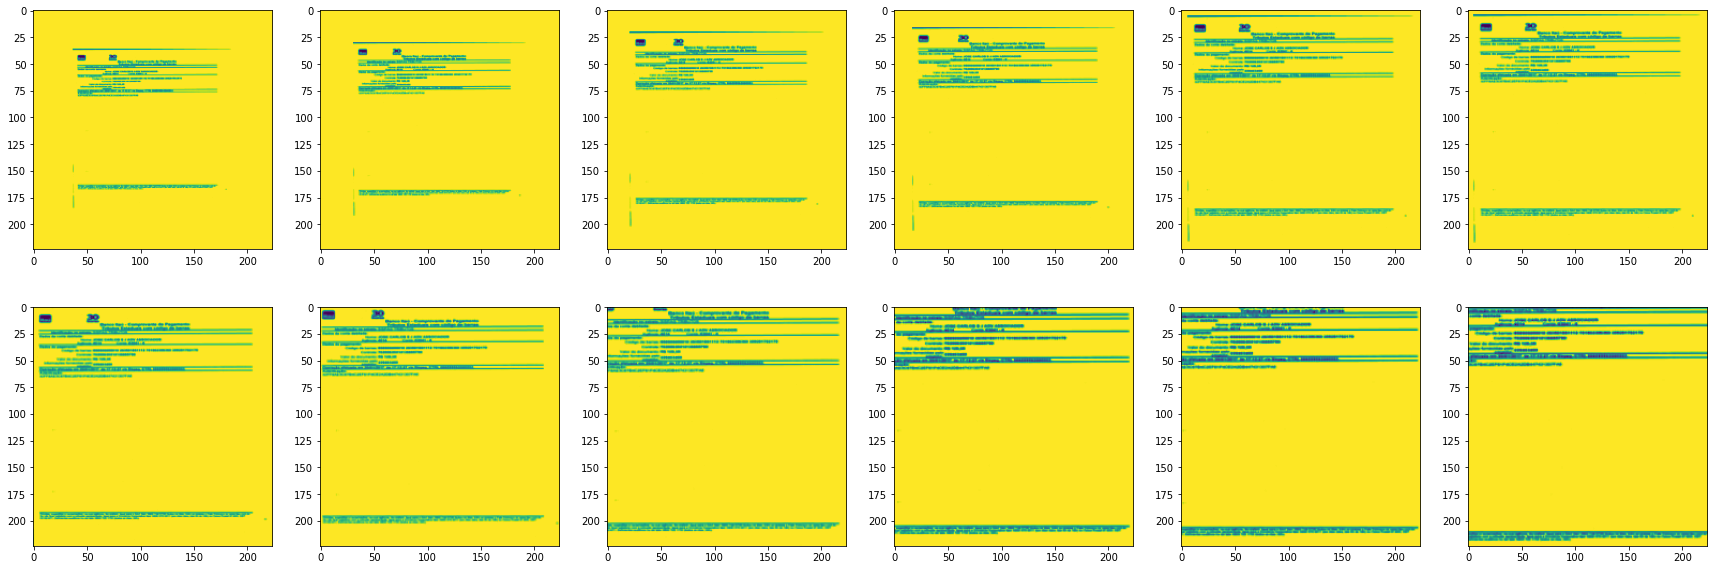

In [ ]:
print_images(img_zoom, 12, 2, 6)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/zoom/'

**ORB**

In [ ]:
# Reseach guias using zoom images as input
search_results = []
num_zoom_bins = img_zoom.shape[0]
for i in range(num_zoom_bins):
  descriptors = ext_orb.predict(img_zoom[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_zoom

### Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_zoom_bins, 500, (0.1, 0.4))

In [ ]:
plot_results(labels, acc_1, 'Accuracy for different levels of zoom for 1 result - ORB', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png')

### Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_zoom_bins, 500, (0.1, 0.4))

In [ ]:
plot_results(labels, acc_5, 'Accuracy for different levels of zoom for 5 results - ORB', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png')

### Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_zoom_bins, 500, (0.1, 0.4))

In [ ]:
plot_results(labels, acc_10, 'Accuracy for different levels of zoom for 10 results - ORB', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top10.ORB.png')

**LBP**

In [ ]:
# Reseach guias using zoom images as input
search_results = []
num_zoom_bins = img_zoom.shape[0]
for i in range(num_zoom_bins):
  descriptors = ext_lbp.predict(img_zoom[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_zoom

Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_1, 'Accuracy for different levels of zoom for 1 result - LBP', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')

Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_5, 'Accuracy for different levels of zoom for 5 result - LBP', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_10, 'Accuracy for different levels of zoom for 10 result - LBP', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')

**HOG**

In [ ]:
# Reseach guias using zoom images as input
search_results = []
num_zoom_bins = img_zoom.shape[0]
for i in range(num_zoom_bins):
  descriptors = model_HOG.predict(img_zoom[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_zoom

Test1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_1, 'Accuracy for different levels of zoom for 1 result - HOG', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Test5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_5, 'Accuracy for different levels of zoom for 5 result - HOG', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Test10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_10, 'Accuracy for different levels of zoom for 10 result - HOG', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using zoom images as input
search_results = []
num_zoom_bins = img_zoom.shape[0]
for i in range(num_zoom_bins):
  descriptors = ext_daisy.predict(img_zoom[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result)

del img_zoom

Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_1, 'Accuracy for different levels of zoom for 1 result - DAISY', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top1_DAISY.png')

Top5 - *test*

In [ ]:
acc_5, labels = get_accuracy(5, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_5, 'Accuracy for different levels of zoom for 5 results - DAISY', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top5_DAISY.png')

Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_zoom_bins, 500, (0.1, 0.4))
plot_results(labels, acc_10, 'Accuracy for different levels of zoom for 10 results - DAISY', 
             'Zoom factor range ', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')

## Noise

Adding random noise can be an attack in image classification. Even being something trivial for a human, random noise can drastically change results on computational applications. We have different ways to put noise into images, and we test some types to analyze the algorithm performance on them.

In [ ]:
#Generates all shifted images
img_noise = []
noises = ['gaussian', 'localvar', 'poisson', 'salt', 'pepper']
for n in noises:
  temp_noise = []
  for img in img_array_list:
    img = random_noise(img, n)
    temp_noise.append(img)
  img_noise.append(temp_noise)
img_noise = np.array(img_noise)

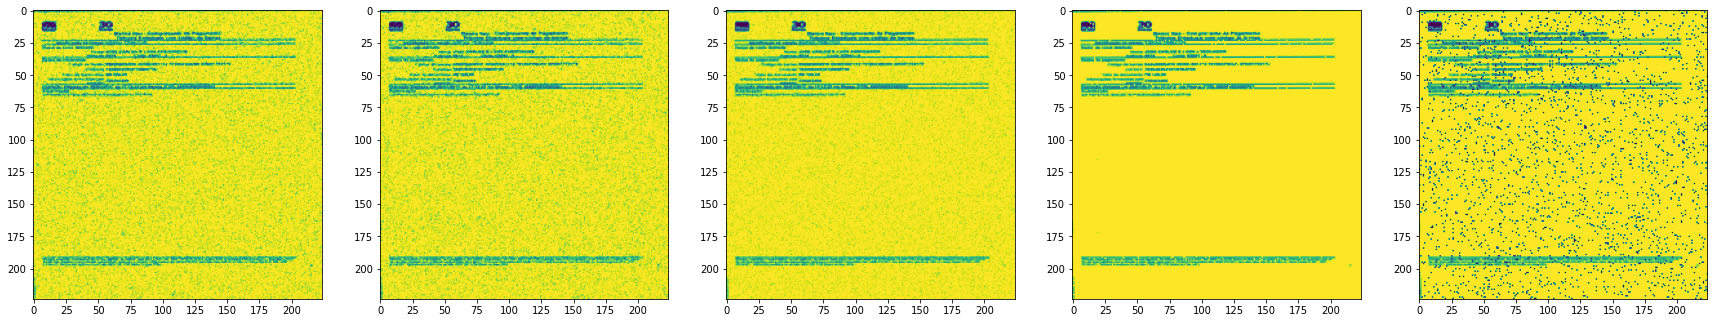

In [ ]:
print_images(img_noise, 5, 1, 5)

In [ ]:
graphics_path='/content/drive/Shareddrives/Projeto_TJSP/graphics/noise/'

**ORB**

In [ ]:
# Reseach guias using noised images as input
search_results = []
num_noise_bins = img_noise.shape[0]
for i in range(num_noise_bins):
  descriptors = ext_orb.predict(img_noise[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result) 

del img_noise

### Top-1 test

In [ ]:
acc_1, labels = get_accuracy(1, num_noise_bins, 500, (0, 0))

In [ ]:
plot_results(noises, acc_1, 'Accuracy for different types of noise for 1 result - ORB', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top1_ORB.png')

### Top-5 test

In [ ]:
acc_5, labels = get_accuracy(5, num_noise_bins, 500, (0, 0))

In [ ]:
plot_results(noises, acc_5, 'Accuracy for different types of noise for 5 results - ORB', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top5_ORB.png')

### Top-10 test

In [ ]:
acc_10, labels = get_accuracy(10, num_noise_bins, 500, (0, 0))

In [ ]:
plot_results(noises, acc_10, 'Accuracy for different types of noise for 10 results - ORB', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top10_ORB.png')

**LBP**

In [ ]:
# Reseach guias using noised images as input
search_results = []
num_noise_bins = img_noise.shape[0]
for i in range(num_noise_bins):
  descriptors = ext_lbp.predict(img_noise[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result) 

del img_noise

Top1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_1, 'Accuracy for different types of noise for 1 result - LBP', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top1_LBP.png')

Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_5, 'Accuracy for different types of noise for 5 results - LBP', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top5_LBP.png')

Top10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_10, 'Accuracy for different types of noise for 10 results - LBP', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top10_LBP.png')

**HOG**

In [ ]:
# Reseach guias using noised images as input
search_results = []
num_noise_bins = img_noise.shape[0]
for i in range(num_noise_bins):
  descriptors = model_HOG.predict(img_noise[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result) 

del img_noise

Top1 - Test

In [ ]:
acc_1, labels = get_accuracy(1, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_1, 'Accuracy for different types of noise for 1 result - HOG', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top1_HOG.png')

Top5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_5, 'Accuracy for different types of noise for 5 results - HOG', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top5_HOG.png')

Top 10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_10, 'Accuracy for different types of noise for 10 results - HOG', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top10_HOG.png')

**DAISY**

In [ ]:
# Reseach guias using noised images as input
search_results = []
num_noise_bins = img_noise.shape[0]
for i in range(num_noise_bins):
  descriptors = ext_daisy.predict(img_noise[i])
  img_result = neighbors.kneighbors(descriptors, 10, return_distance=False)
  search_results.append(img_result) 

del img_noise

Top 1 - test

In [ ]:
acc_1, labels = get_accuracy(1, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_1, 'Accuracy for different types of noise for 1 result - DAISY', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top1_DAISY.png')

Top 5 - test

In [ ]:
acc_5, labels = get_accuracy(5, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_5, 'Accuracy for different types of noise for 5 results - DAISY', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top5_DAISY.png')

Top 10 - test

In [ ]:
acc_10, labels = get_accuracy(10, num_noise_bins, 500, (0, 0))
plot_results(noises, acc_10, 'Accuracy for different types of noise for 10 results - DAISY', 
             'Noise type', 'Accuracy')
plt.savefig(graphics_path+'top10_DAISY.png')